Элементарные методы анализа временных рядов

### Подготовка данных

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [15]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [16]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

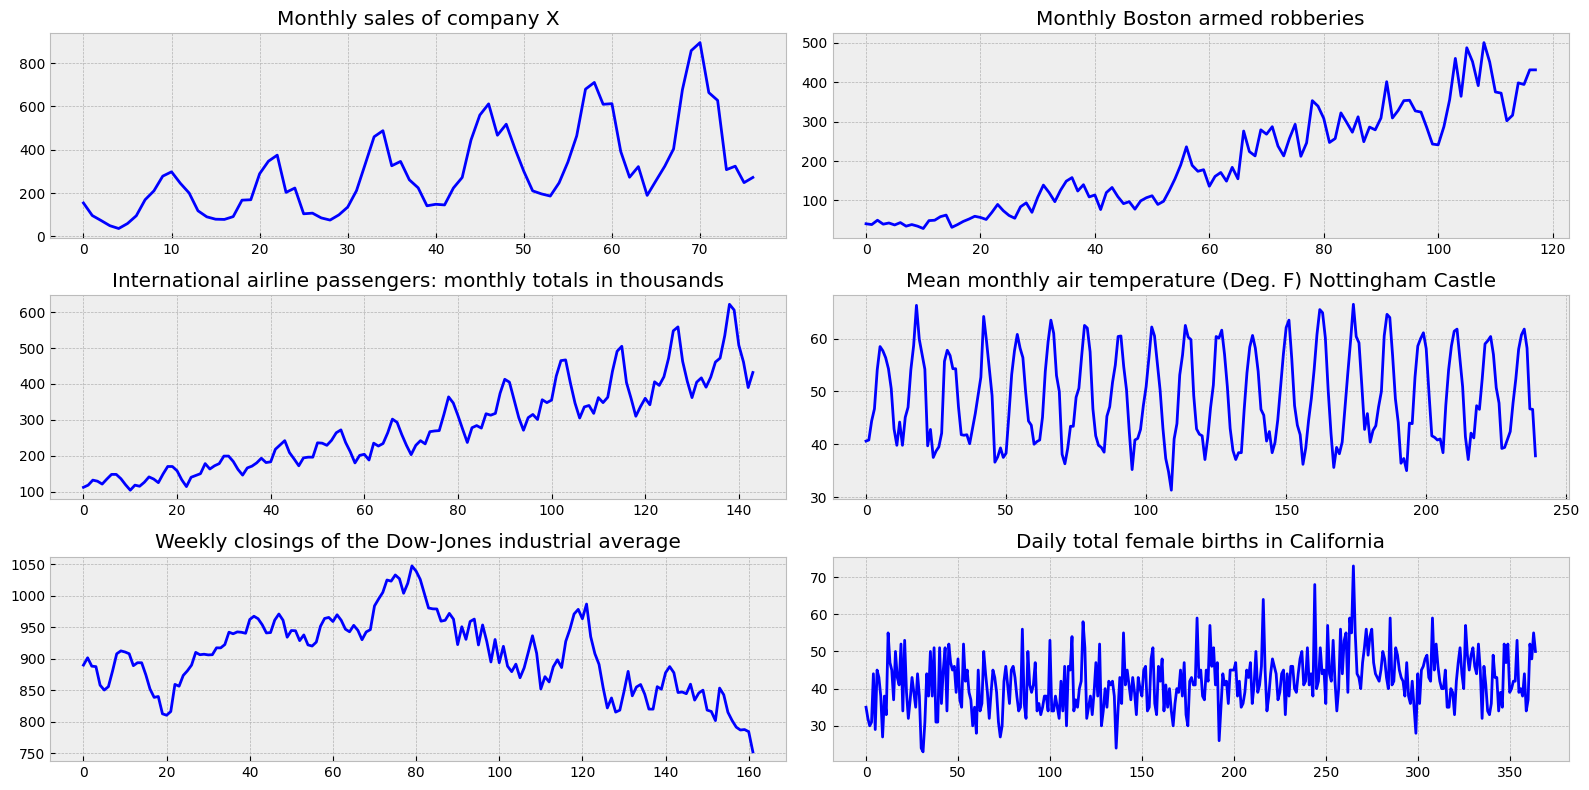

In [17]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [18]:

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [19]:

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Выбор стационарного и не стационарного ряда

Не стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


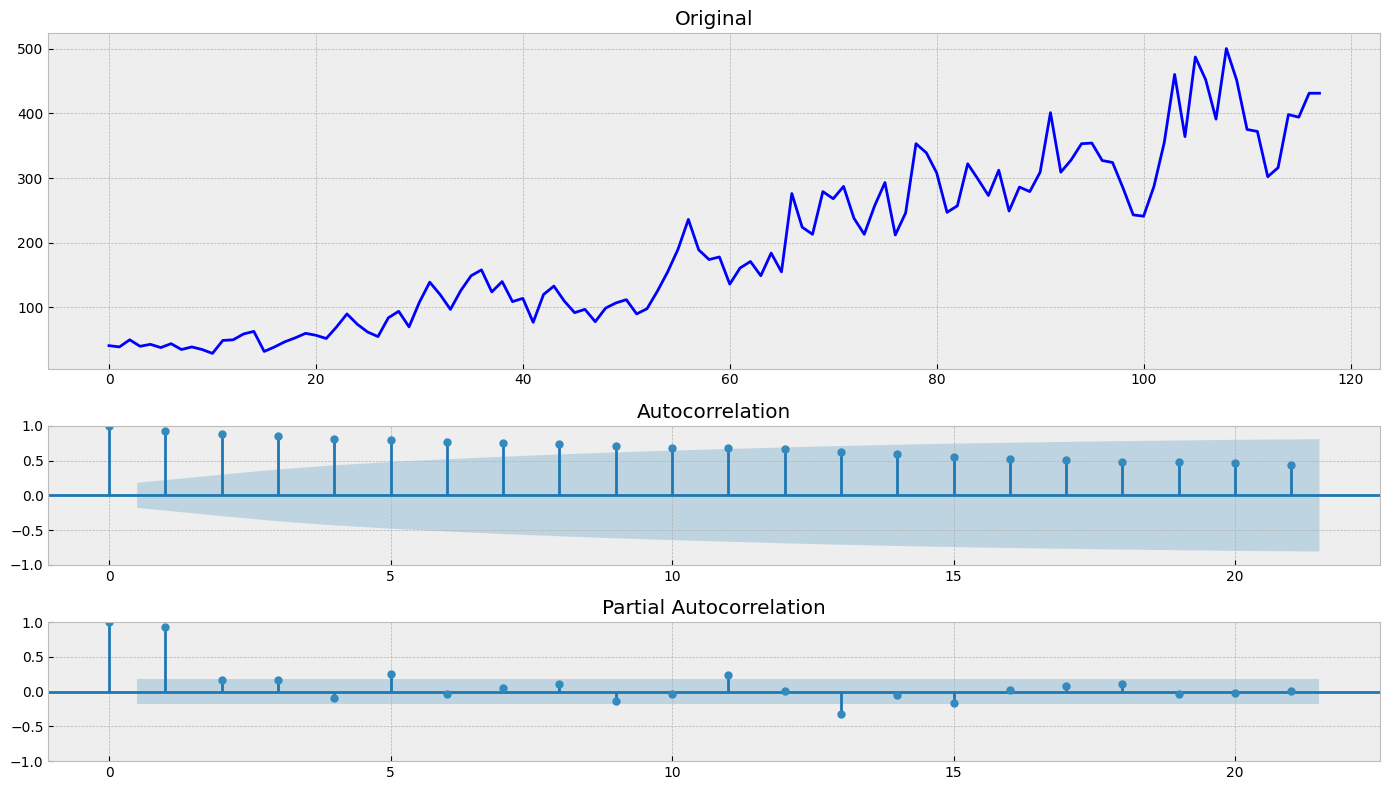

In [20]:
non_stationary_series = all_series["Monthly Boston armed robberies"]
tsplot(non_stationary_series)

Стационарный

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


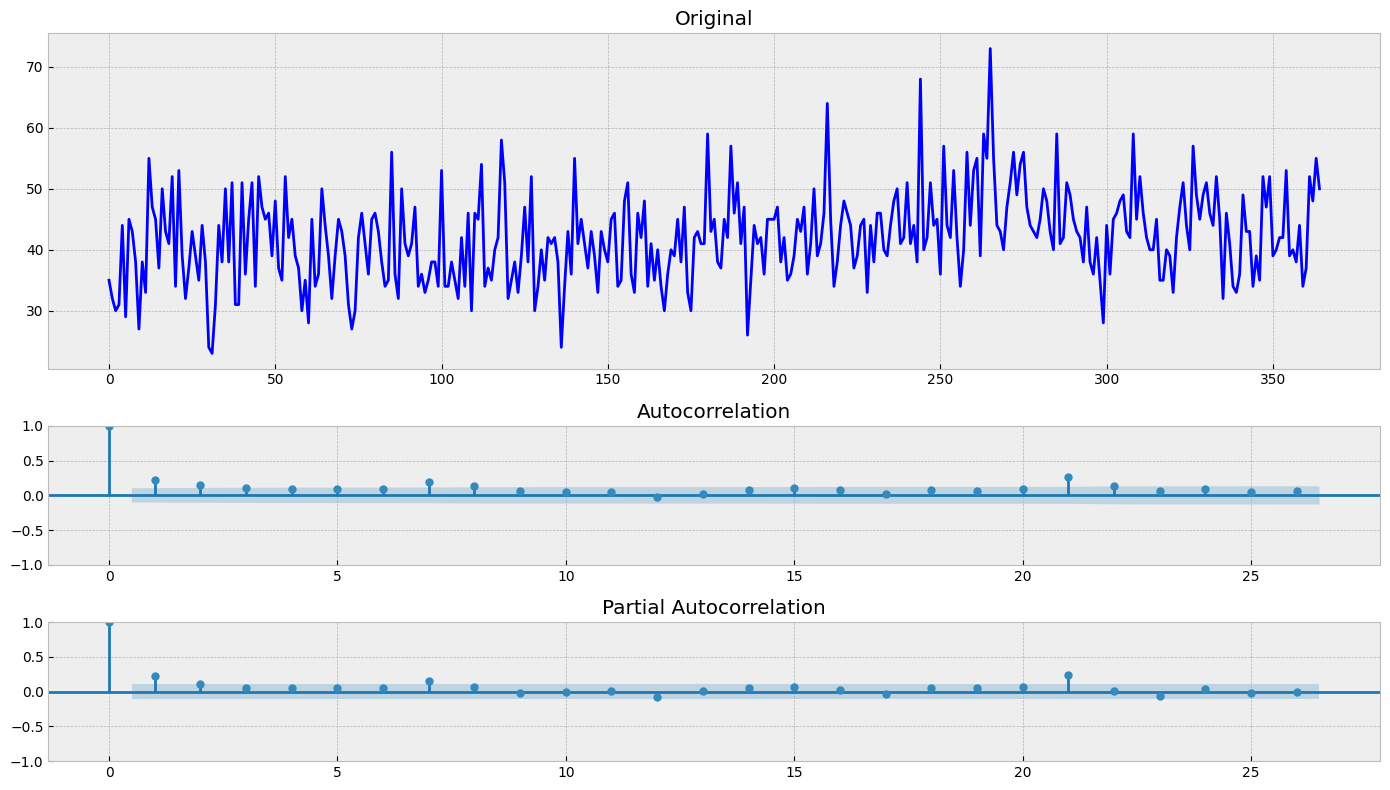

In [21]:
stationary_series = all_series["Daily total female births in California"]
tsplot(stationary_series)

Приближение рядов моделями из МА

In [22]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

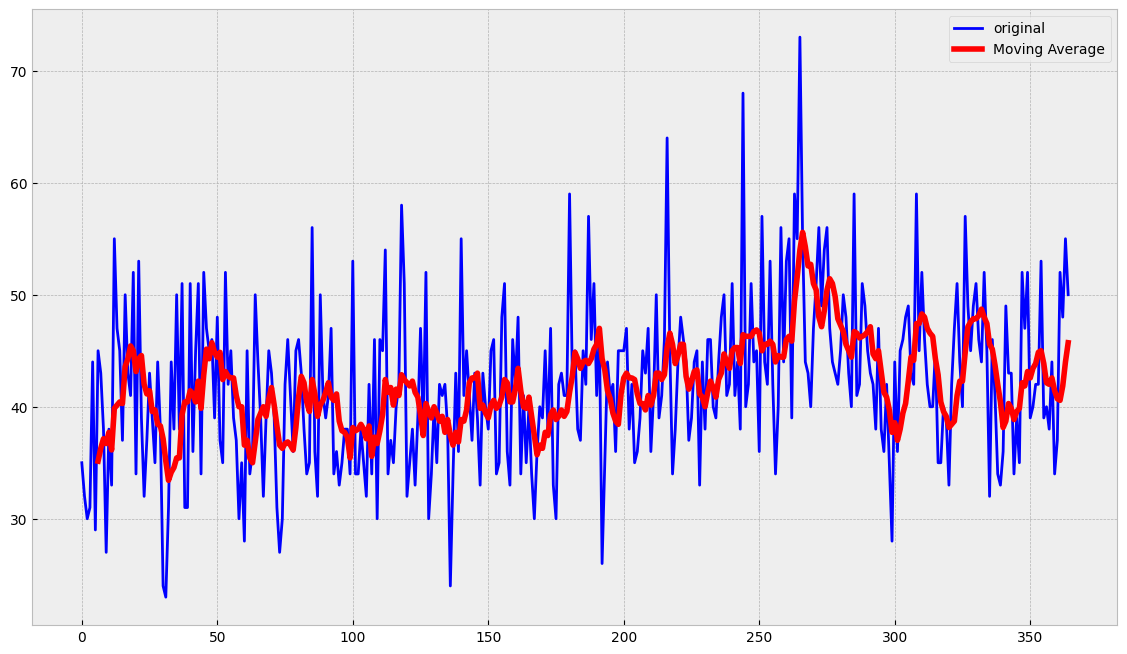

In [23]:
ser = moving_average(stationary_series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stationary_series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [43]:
class MA:
  def __init__(self, series, weights=None, alpha=0.1, beta=0.1):
    self.current_series = series.copy()
    self.series = series.copy()
    self.weights = weights
    self.alpha = alpha
    self.beta = beta

  def predict(self, model_name, n=0, n_pred=0):
    self.series = self.series[:-n_pred]

    match model_name:
      case "moving_average":
        self._predict_moving_average(n, n_pred)
      case "weighted_moving_average":
        self._predict_weighted_moving_average(n, n_pred)
      case "exponential_moving_average":
        self._exponential_moving_average(n_pred, self.alpha)
      case "double_exponential_moving_average":
        self._double_exponential_moving_average(self.alpha, self.beta, n_pred)
      case _:
        print("Nothing was executing!")

    self._show(n_pred, model_name)

  def _show(self, n_pred, model_name):
    with plt.style.context('bmh'):
      plt.figure(figsize=(14, 8))
      plt.plot(self.current_series[:-n_pred], color='blue', linewidth='4', label='Real')
      plt.plot(self.current_series[-n_pred:], color='orange', linewidth='4', label='Real')
      plt.plot(self.series[-n_pred:], color='green', linewidth='2', label='Pred')
      plt.title(model_name)

      plt.legend()

  def _predict_moving_average(self, N, n_pred):
    for _ in range(n_pred):
        self.series = self.series.append(pd.Series([self.series[-N:].mean()]), ignore_index=True)
    return self.series

  def _predict_weighted_moving_average(self, N, n_pred):
    result = 0.0
    # self.weights.reverse()
    for _ in range(n_pred):
      for n in range(len(self.weights)):
        result += self.series.iloc[-n-1] * self.weights[n]
      result /= sum(self.weights)
      self.series = self.series.append(pd.Series([result]), ignore_index=True)

  def _exponential_moving_average(self, n_pred, alpha):
    result = [self.series.iloc[-2]]
    for n in range(1, n_pred):
      res = self.alpha * self.series.iloc[-1] + (1 - self.alpha) * result[-1]
      result = np.append(result, res)
      self.series = self.series.append(pd.Series([res]), ignore_index=True)

  def _double_exponential_moving_average(self, alpha, beta, n_pred):
    result = [self.series[0]]
    level, trend = self.series[0], self.series[1] - self.series[0]
    for n in range(1, len(self.series)):
        value = self.series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_pred):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    self.series = self.series.append(pd.Series(preds), ignore_index=True)




#### Применение моделей МА

<ipython-input-43-dab75b9a22ae>:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series([self.series[-N:].mean()]), ignore_index=True)
<ipython-input-43-dab75b9a22ae>:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series([result]), ignore_index=True)
<ipython-input-43-dab75b9a22ae>:55: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series([res]), ignore_index=True)
<ipython-input-43-dab75b9a22ae>:74: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series(preds), ignore_index=True)


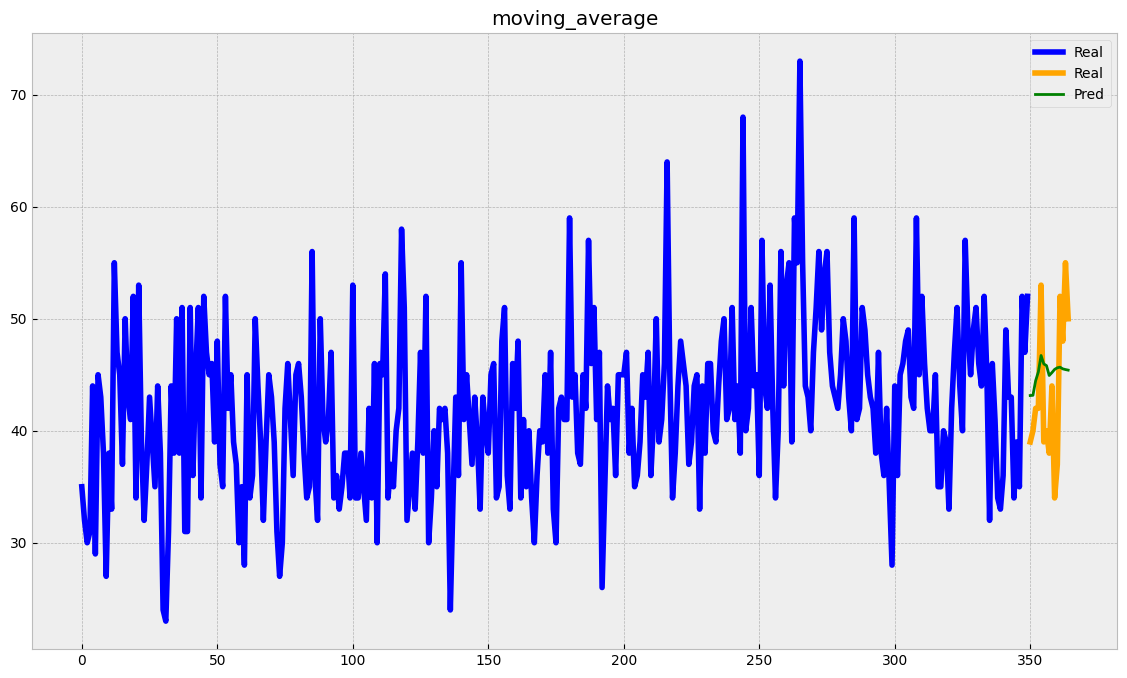

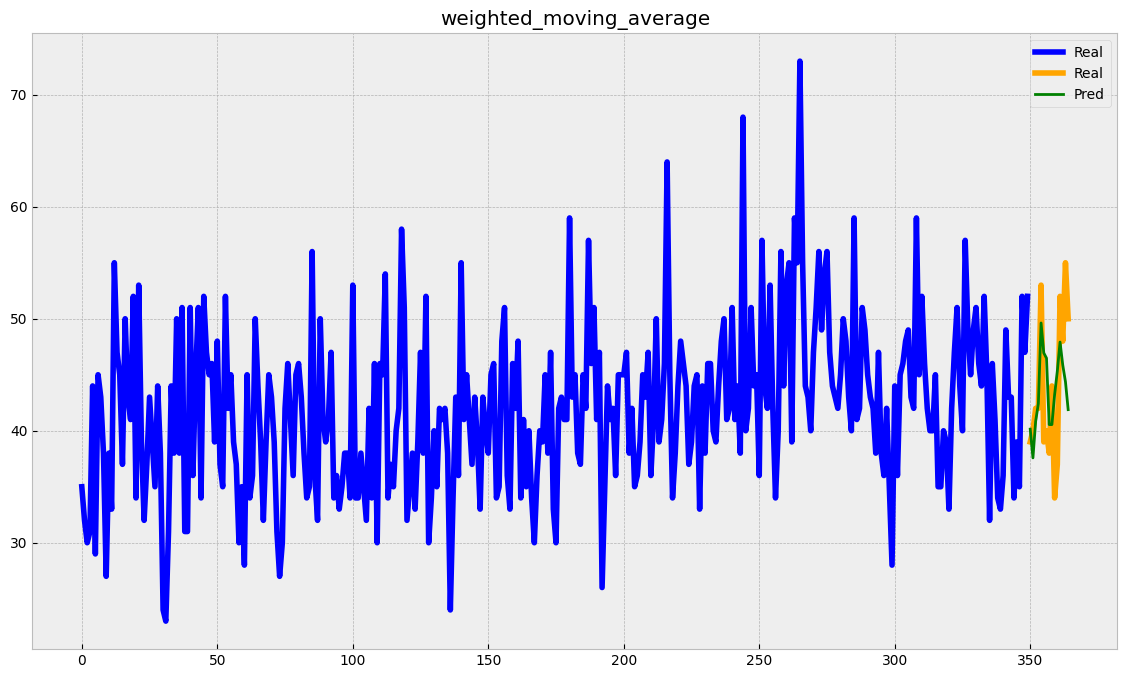

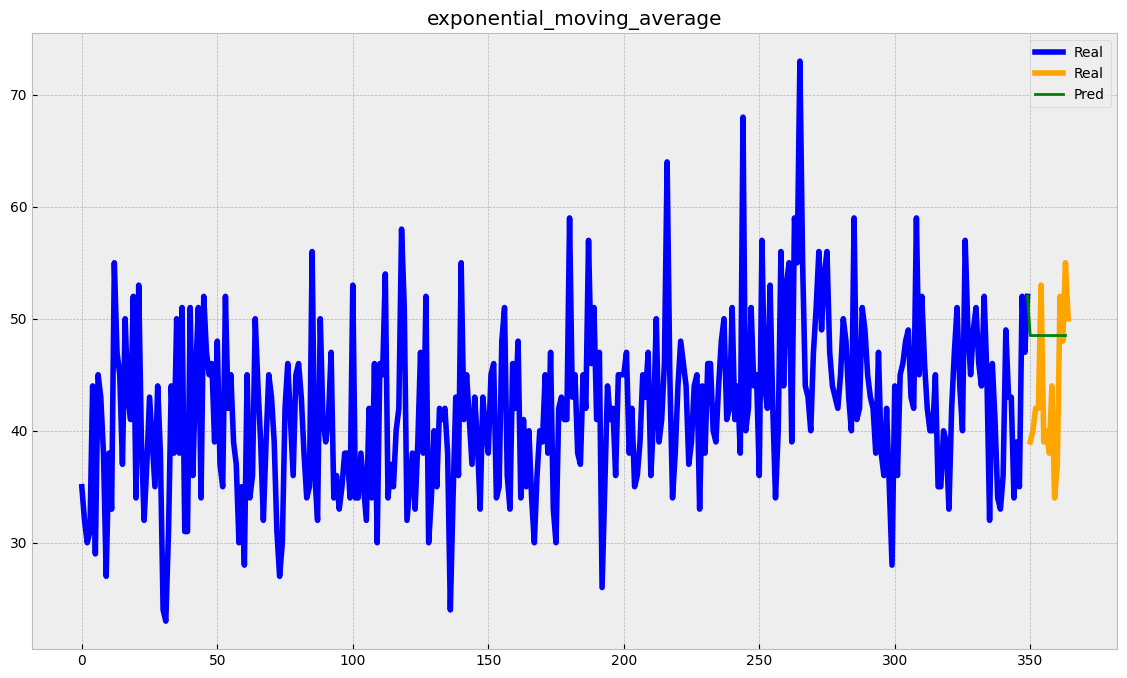

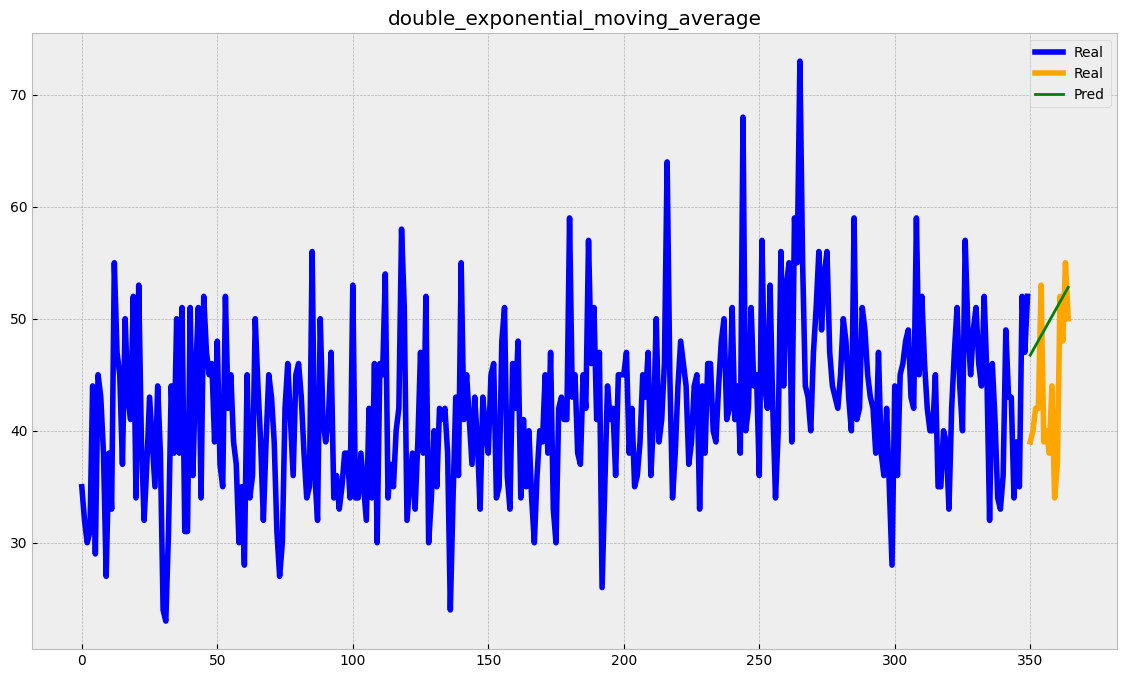

In [50]:
MA(stationary_series).predict("moving_average", 7, 15)
MA(stationary_series, [1,2,4,8,16,32,64]).predict("weighted_moving_average", 7, 15)
MA(stationary_series, alpha=0.3).predict("exponential_moving_average", n_pred=15)
MA(stationary_series, alpha=0.3, beta=0.1).predict("double_exponential_moving_average", n_pred=15)

<ipython-input-43-dab75b9a22ae>:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series([self.series[-N:].mean()]), ignore_index=True)
<ipython-input-43-dab75b9a22ae>:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series([result]), ignore_index=True)
<ipython-input-43-dab75b9a22ae>:55: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series([res]), ignore_index=True)
<ipython-input-43-dab75b9a22ae>:74: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.series = self.series.append(pd.Series(preds), ignore_index=True)


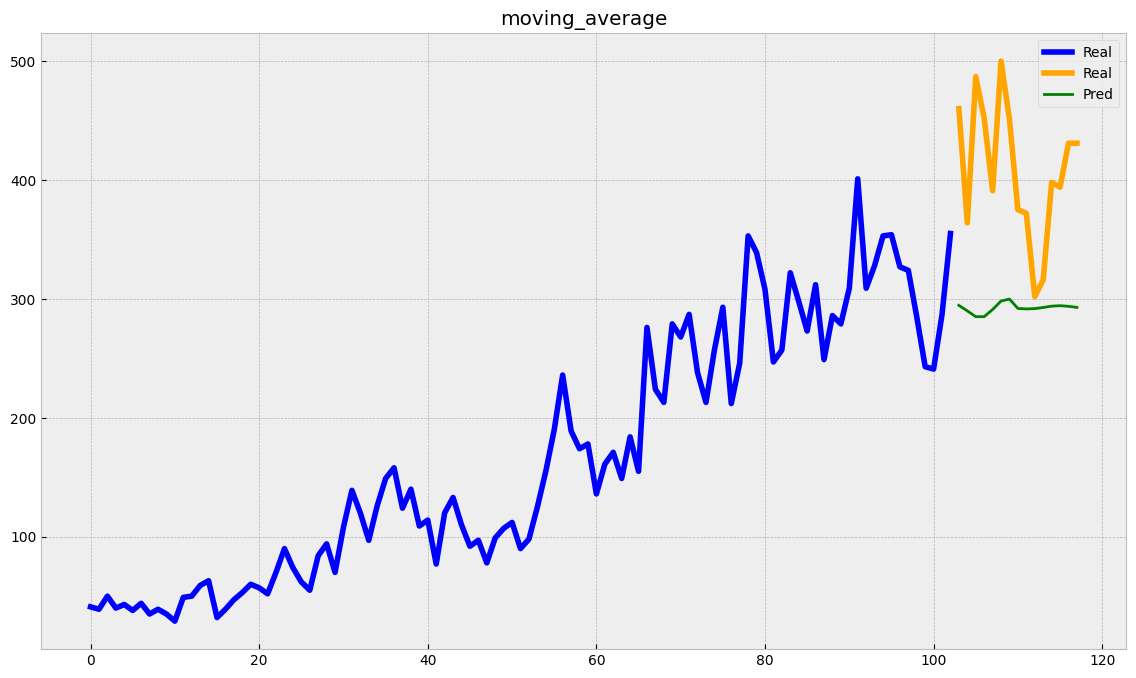

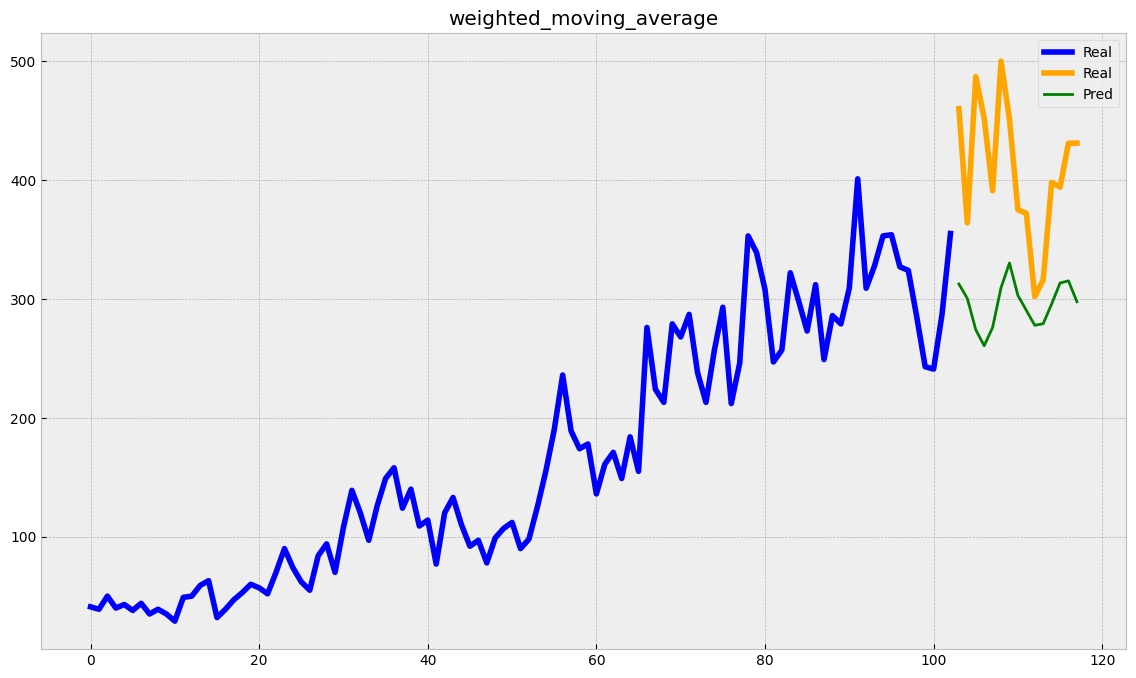

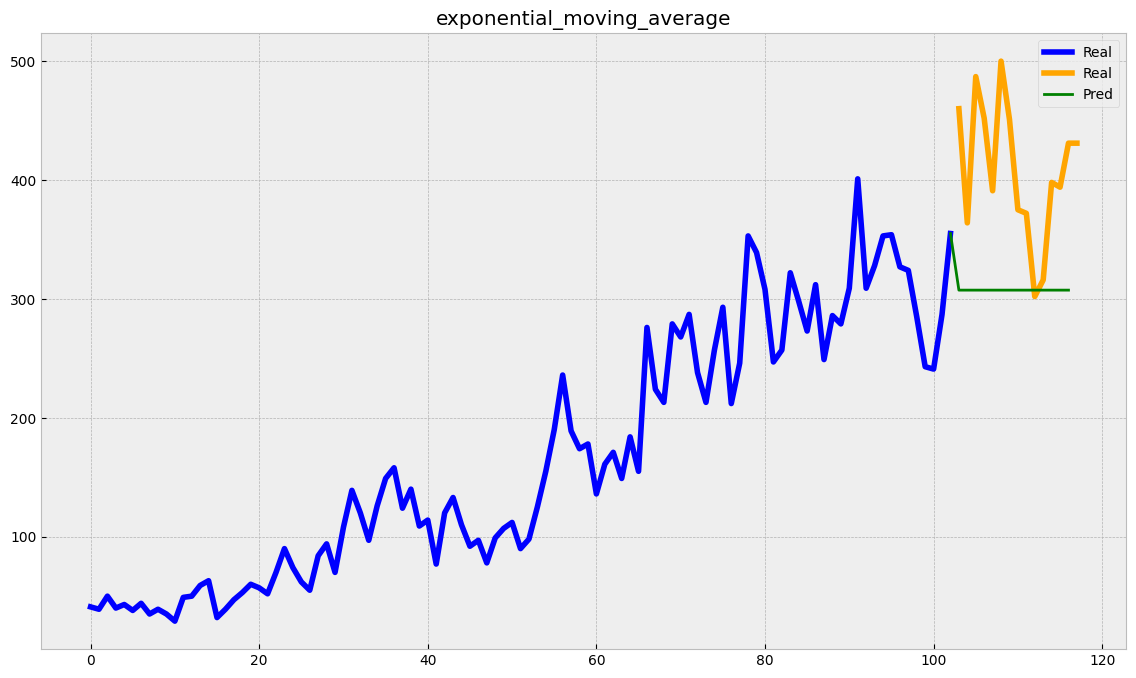

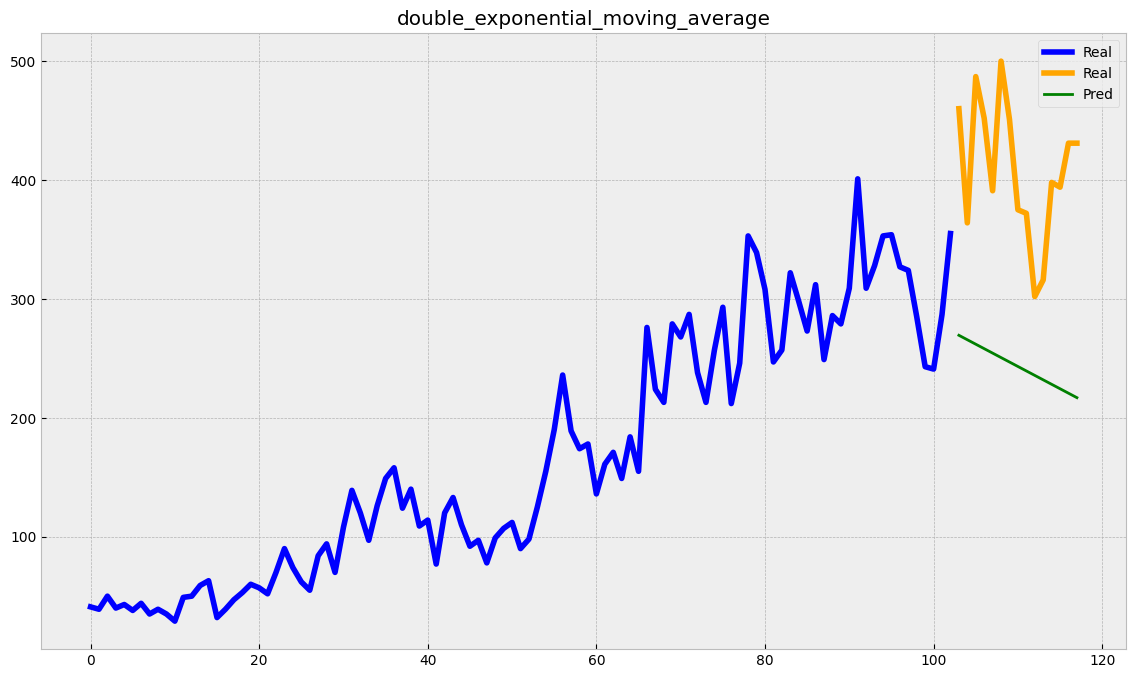

In [51]:
MA(non_stationary_series).predict("moving_average", 7, 15)
MA(non_stationary_series, [1,2,4,8,16,32,64]).predict("weighted_moving_average", 7, 15)
MA(non_stationary_series, alpha=0.3).predict("exponential_moving_average", n_pred=15)
MA(non_stationary_series, alpha=0.3, beta=0.4).predict("double_exponential_moving_average", n_pred=15)

### Выводы

В ходе работы испльзовалось 4 модели МА:
  1. Скользящее среднее

    Плюс:
      + В случае сильно зашумленных данных скользящее среднее помогает определить тренд

    Минус:
      - Повышенная чувствительность к выбросам данных
  2. Взвешенное скользящее среднее

    Плюс:
      + Чем раньше было событие - тем меньше оно влияет на прогнозируемое значение

    Минус:
      - Повышенная чувствительность к выбросам данных
  3. Экспоненциальное сглаживание

    Плюс:
      + Учитывает временной контекст

    Минус:
      - Не учитывает временные компоненты, такие как тренд или сезонность
  4. Двойное экспоненциальное сглаживание (DEMA)

    Плюс:
      + Учитывает временной контекст
      + Берёт в расчёт трендовую составляющую

    Минус:
      - «Ломается», если подать на вход временной ряд, имеющий сезонность

После применения моделей к стационарному и не стационарному ряду видно, что лучшие результаты были после применения моделей на стационарном ряде.

Для не стационарного ряда больше подойдут модели которые не чувствительны к выбросам, циклам и сезонности.

А для стационарного, соответсвенно, подойдут те модели которым не важны выбросы, циклы и сезонности.